In [1]:
import sbvar as sb
import tellurium as te
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import seaborn as sns
sns.set_context('paper')

from matplotlib import rcParams

rcParams["savefig.transparent"] = True
rcParams['figure.facecolor'] = (1,1,1,0)
rcParams['axes.facecolor'] = (1,1,1,0)
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150
rcParams["savefig.format"] = 'png'
rcParams["savefig.bbox"] = 'tight'
rcParams["axes.grid"] = False
rcParams["figure.figsize"] = (3,3)


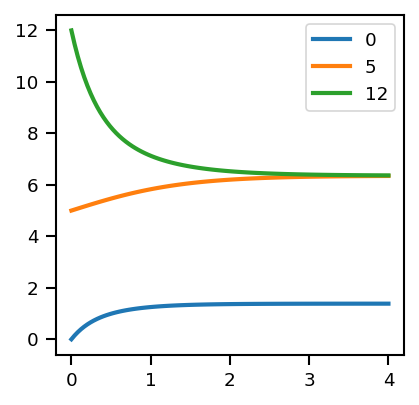

In [3]:
rr = te.loada ('''
$Xo -> S1; 1 + Xo*(32+(S1/0.75)^3.2)/(1 +(S1/4.3)^3.2);
S1 -> $X1; k1*S1;

Xo = 0.09; X1 = 0.0;
S1 = 0.5; k1 = 3.2;
''')
rr['S1'] = 0
y1 = rr.simulate(0, 4, 100, ['Time','S1'])
rr.reset()
rr['S1'] = 5
y2 = rr.simulate(0, 4, 100, ['S1'])
rr.reset()
rr['S1'] = 12
y3 = rr.simulate(0, 4, 100, ['S1'])
plt.figure()
ax = te.plotArray(np.hstack([y1, y2, y3]), labels=[0, 5, 12])


In [4]:
exp = sb.experiment.OneWayExperiment(rr, param='S1', 
    bounds=(0,12), num=40, start=0, end=4, points=100)

In [5]:
exp.simulate()
exp.calc_steady_state()

(<Figure size 450x450 with 1 Axes>,
 <AxesSubplot:title={'center':'S1'}, xlabel='Time', ylabel='S1'>)

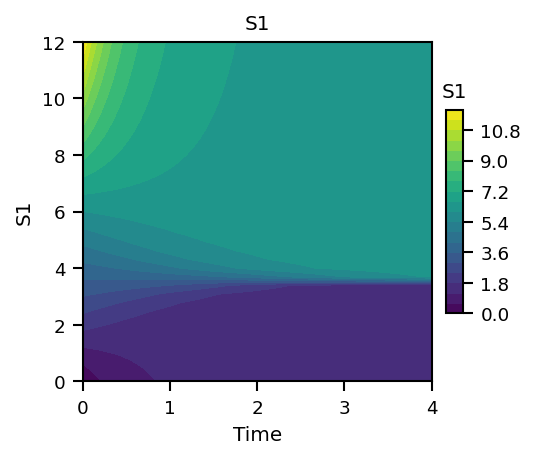

In [6]:
exp.plot_timecourse_mesh('S1', levels=20)

(<Figure size 450x450 with 1 Axes>, <Axes3DSubplot:xlabel='Time', ylabel='S1'>)

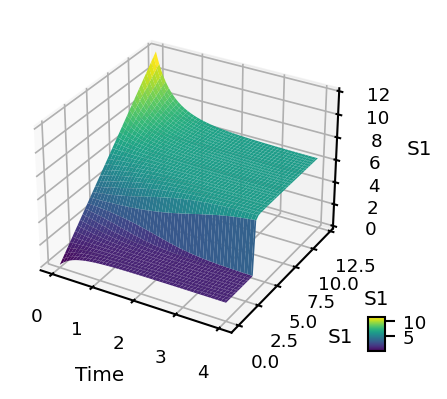

In [7]:
exp.plot_timecourse_mesh('S1', kind='surface', projection='3d')
